# Causal Inference

## Import the Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import causalnex
import sys
import os
import mlflow
from sklearn.preprocessing import LabelEncoder
from IPython.display import Markdown, display, Image, display_html

from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.utils.network_utils import get_markov_blanket
from causalnex.structure import StructureModel
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import jaccard_score

C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### pip freeze

In [2]:
#sm = causalnex.structure.StructureModel

### Load Data

In [3]:
data=pd.read_csv('../data/data.csv')
data.drop('Unnamed: 32', axis=1, inplace=True)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
data.shape

(569, 32)

### Feature Extraction

In [5]:
#Separating features from the target variable
features_df = data.drop('diagnosis',axis=1)
target_df = data['diagnosis']

In [6]:
features_df.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
target_df.head()

0    M
1    M
2    M
3    M
4    M
Name: diagnosis, dtype: object

### Check and remove outliers

In [8]:
# add scripts
sys.path.append(os.path.abspath("../scripts/"))
from utils import Utils
utils = Utils("../logs/modeling.logs")

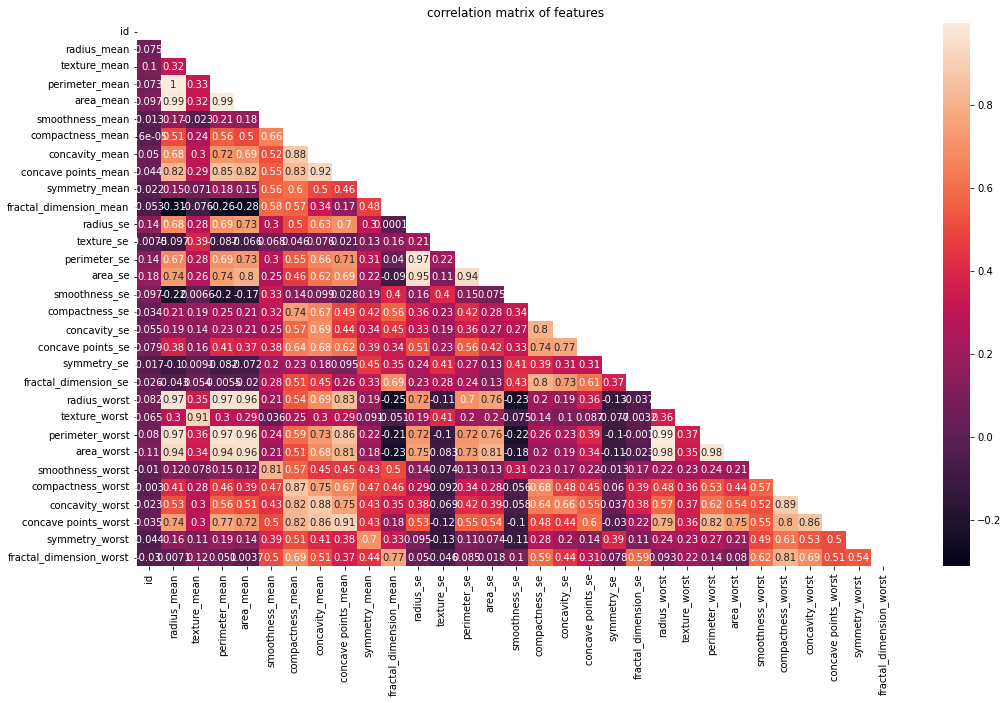

In [9]:
#### Eliminating highly related features
utils.show_corr(features_df, "correlation matrix of features", save=True, name="features_correlation.png")

Removing highly correlated features

In [10]:
features_df2 = utils.remove_correlated(features_df, 0.9)
features_df2.head()

INFO:utils:correlated variables successfully removed


number of correlated variables: 10
..................................................
correlated features:  {'area_se', 'area_worst', 'perimeter_mean', 'concave points_mean', 'perimeter_worst', 'texture_worst', 'radius_worst', 'perimeter_se', 'concave points_worst', 'area_mean'}


,id,radius_mean,texture_mean,smoothness_mean,compactness_mean,concavity_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,...,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst
0,842302,17.99,10.38,0.11840,0.27760,0.3001,0.2419,0.07871,1.0950,0.9053,...,0.04904,0.05373,0.01587,0.03003,0.006193,0.1622,0.6656,0.7119,0.4601,0.11890
1,842517,20.57,17.77,0.08474,0.07864,0.0869,0.1812,0.05667,0.5435,0.7339,...,0.01308,0.01860,0.01340,0.01389,0.003532,0.1238,0.1866,0.2416,0.2750,0.08902
2,84300903,19.69,21.25,0.10960,0.15990,0.1974,0.2069,0.05999,0.7456,0.7869,...,0.04006,0.03832,0.02058,0.02250,0.004571,0.1444,0.4245,0.4504,0.3613,0.08758
3,84348301,11.42,20.38,0.14250,0.28390,0.2414,0.2597,0.09744,0.4956,1.1560,...,0.07458,0.05661,0.01867,0.05963,0.009208,0.2098,0.8663,0.6869,0.6638,0.17300
4,84358402,20.29,14.34,0.10030,0.13280,0.1980,0.1809,0.05883,0.7572,0.7813,...,0.02461,0.05688,0.01885,0.01756,0.005115,0.1374,0.2050,0.4000,0.2364,0.07678


Select the important features

In [11]:
selected_feat = utils.select_features_RFE(features_df2, target_df, 10)
selected_feat.head()

INFO:utils:successfully selected features


,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst
0,17.99,10.38,0.11840,0.3001,1.0950,0.04904,0.1622,0.6656,0.7119,0.4601
1,20.57,17.77,0.08474,0.0869,0.5435,0.01308,0.1238,0.1866,0.2416,0.2750
2,19.69,21.25,0.10960,0.1974,0.7456,0.04006,0.1444,0.4245,0.4504,0.3613
3,11.42,20.38,0.14250,0.2414,0.4956,0.07458,0.2098,0.8663,0.6869,0.6638
4,20.29,14.34,0.10030,0.1980,0.7572,0.02461,0.1374,0.2050,0.4000,0.2364


### Scaling and Normalizing the Dataset

In [12]:
scaled = utils.scale_and_normalize(selected_feat)
scaled.head()

INFO:utils:variables scaled successfully
INFO:utils:variables normalized succesfully
INFO:utils:variables successfully scaled and normalized


,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst
0,0.311623,0.013551,0.355113,0.420535,0.213005,0.210165,0.359528,0.370387,0.340075,0.357930
1,0.685209,0.290401,0.308840,0.216925,0.166668,0.086642,0.370285,0.164673,0.205593,0.248868
2,0.448247,0.290830,0.383274,0.344673,0.171119,0.211609,0.360381,0.287189,0.268089,0.300850
3,0.101686,0.174650,0.392688,0.273759,0.067322,0.262922,0.443099,0.393991,0.265549,0.484011
4,0.562838,0.139909,0.384539,0.414532,0.208931,0.150043,0.390805,0.154061,0.285478,0.140734


## Causal Analysis

First, we start by rejoining the features to the target variable and then label encode the target variable (<em>diagnosis</em>)

In [13]:
causal_df = selected_feat.copy()
causal_df["target"] = LabelEncoder().fit_transform(target_df)
causal_df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,target
0,17.99,10.38,0.11840,0.3001,1.0950,0.04904,0.1622,0.6656,0.7119,0.4601,1
1,20.57,17.77,0.08474,0.0869,0.5435,0.01308,0.1238,0.1866,0.2416,0.2750,1
2,19.69,21.25,0.10960,0.1974,0.7456,0.04006,0.1444,0.4245,0.4504,0.3613,1
3,11.42,20.38,0.14250,0.2414,0.4956,0.07458,0.2098,0.8663,0.6869,0.6638,1
4,20.29,14.34,0.10030,0.1980,0.7572,0.02461,0.1374,0.2050,0.4000,0.2364,1


We then divided the dataset into ratios of 20, 40, 60, 10 and 100 percent

In [14]:
factor = len(causal_df)/100
causal_20 = causal_df.sample(int(20*factor), random_state=11)
print(f"size of causal_20 : {len(causal_20)}")
causal_40 = causal_df.sample(int(40*factor), random_state=11)
print(f"size of causal_40 : {len(causal_40)}")
causal_60 = causal_df.sample(int(60*factor), random_state=11)
print(f"size of causal_60 : {len(causal_60)}")
causal_80 = causal_df.sample(int(80*factor), random_state=11)
print(f"size of causal_80 : {len(causal_80)}")
print(f"size of causal_100 : {len(causal_df)}")

size of causal_20 : 113
size of causal_40 : 227
size of causal_60 : 341
size of causal_80 : 455
size of causal_100 : 569


<b>Generate the ground truth structure</b>

In [15]:
ground_truth = from_pandas(causal_df, tabu_parent_nodes=["target"])

<b>Generate the structures from fractional datasets</b>

In [20]:
sm20 = from_pandas(causal_20, tabu_parent_nodes=["target"])
sm40 = from_pandas(causal_40, tabu_parent_nodes=["target"])
sm60 = from_pandas(causal_60, tabu_parent_nodes=["target"])
sm80 = from_pandas(causal_80, tabu_parent_nodes=["target"])

## Plotting and comparing stability of the Graphs at different ratios

In [21]:
utils.plot_graph(ground_truth, 0.6, True, "groud_truth_graph.png")

INFO:utils:treshold successfully applied
C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'radius_mean', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


### Selecting the nodes and edges

In [22]:
feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']
len(feat)

31

In [23]:
x = data[feat[:29]]
x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)
x.head(5)

C:\Users\wakur\AppData\Local\Temp\ipykernel_17304\1331229971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['diagnosis'] = x['diagnosis'].apply(lambda x: 1 if x == "M" else 0)


,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,...,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,2019.0,25.38,0.2654,0.14710,122.80,1001.0,17.99,153.40,...,10.38,0.4601,0.05373,0.11840,0.2419,0.04904,0.11890,0.006193,0.9053,0.07871
1,1,158.80,1956.0,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,...,17.77,0.2750,0.01860,0.08474,0.1812,0.01308,0.08902,0.003532,0.7339,0.05667
2,1,152.50,1709.0,23.57,0.2430,0.12790,130.00,1203.0,19.69,94.03,...,21.25,0.3613,0.03832,0.10960,0.2069,0.04006,0.08758,0.004571,0.7869,0.05999
3,1,98.87,567.7,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,...,20.38,0.6638,0.05661,0.14250,0.2597,0.07458,0.17300,0.009208,1.1560,0.09744
4,1,152.20,1575.0,22.54,0.1625,0.10430,135.10,1297.0,20.29,94.44,...,14.34,0.2364,0.05688,0.10030,0.1809,0.02461,0.07678,0.005115,0.7813,0.05883


In [24]:
sm = from_pandas(x.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

In [25]:
def vis_sm(sm):
  viz = plot_structure(
      sm,
      graph_attributes={"scale": "2.0", 'size': 2.5},
      all_node_attributes=NODE_STYLE.WEAK,
      all_edge_attributes=EDGE_STYLE.WEAK)
  return Image(viz.draw(format='png'))

C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


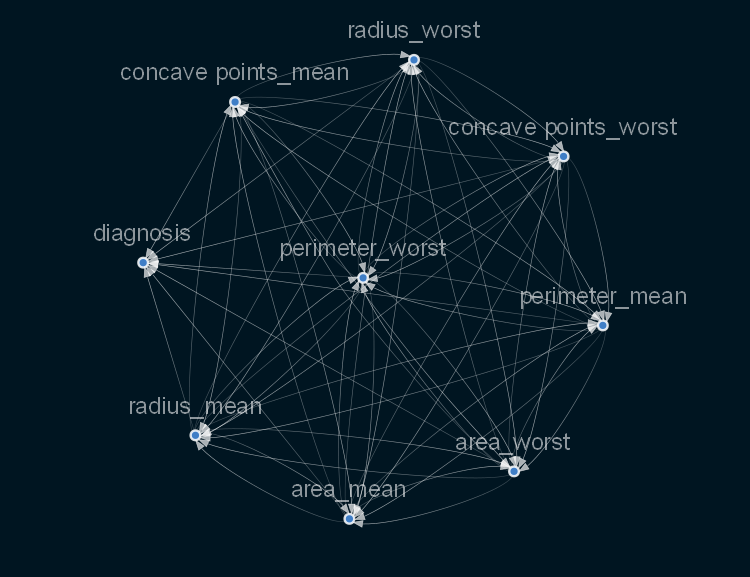

In [26]:
vis_sm(sm)

C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


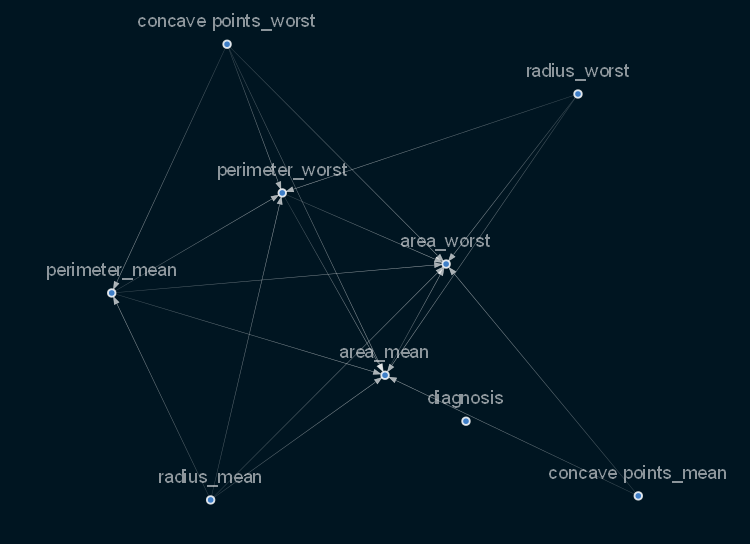

In [27]:
sm.remove_edges_below_threshold(0.8)
vis_sm(sm)

##### <b>50%</b>
##### Selecting all the rows and the first 10 columns

In [28]:
x_selected = x.iloc[:, :10]
portion = int(x_selected.shape[0] *.5)
x_portion = x_selected.head(portion)

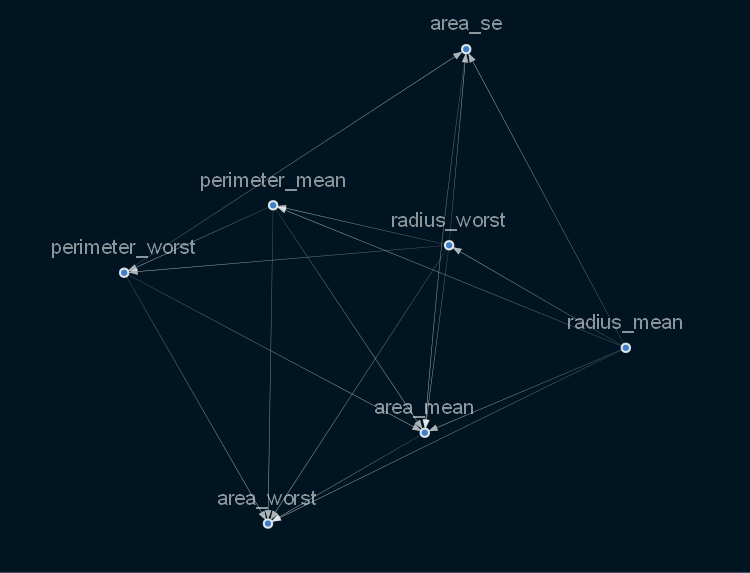

In [30]:
sm1 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm1 = sm1.get_largest_subgraph()
vis_sm(sm1)

#### 60%

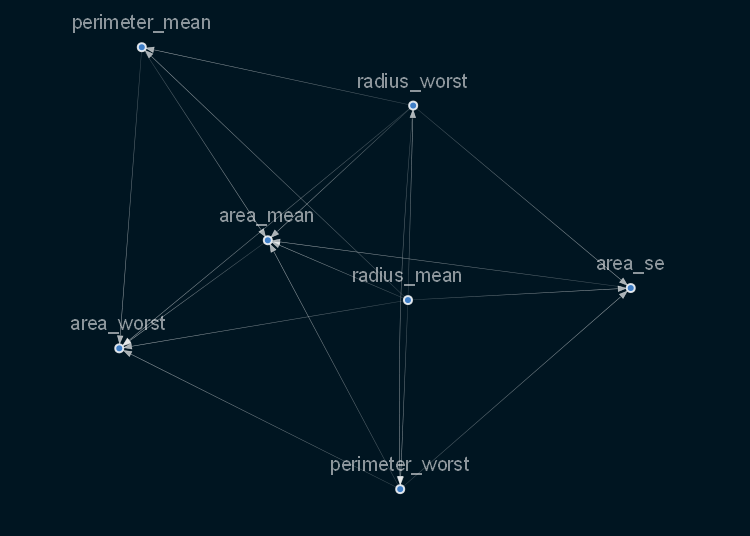

In [31]:
portion = int(x_selected.shape[0]*.6)
x_portion = x_selected.head(portion)

sm2 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm2 = sm2.get_largest_subgraph()
vis_sm(sm2)

#### 70%

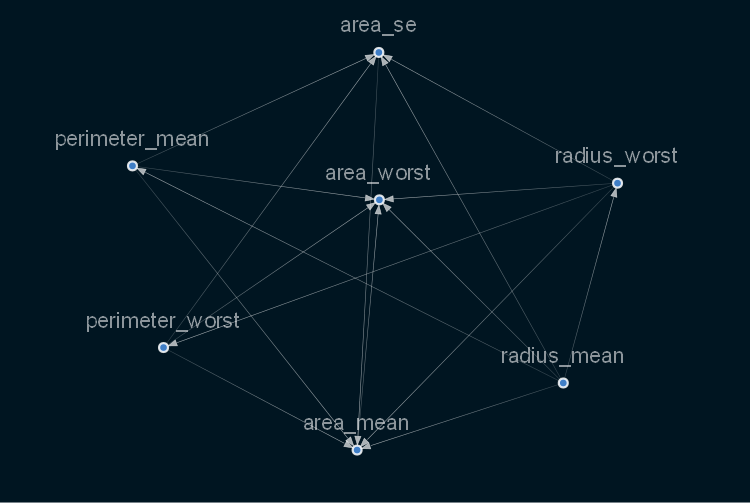

In [32]:
portion = int(x_selected.shape[0]*.7)
x_portion = x_selected.head(portion)

sm3 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm3 = sm3.get_largest_subgraph()
vis_sm(sm3)

#### 80%

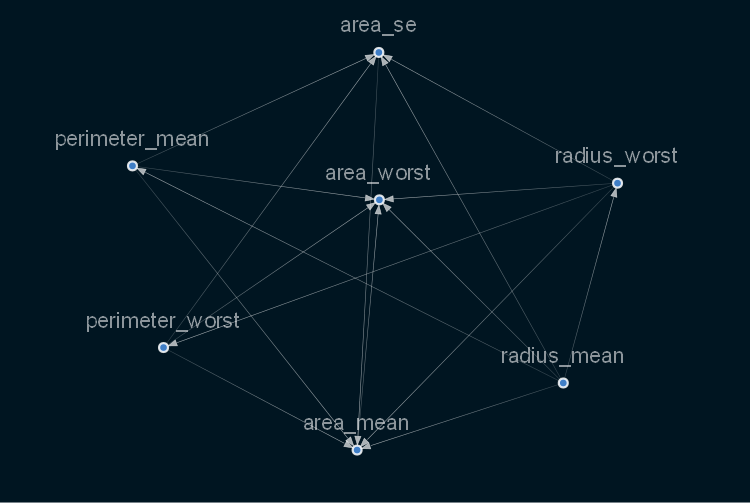

In [33]:
portion = int(x_selected.shape[0]*.8)
x_portion = x_selected.head(portion)

sm4 = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm4 = sm4.get_largest_subgraph()
vis_sm(sm4)

### Comparing the Graphs using Jaccard index

We will compute the Jaccard index in this way:
<ol>
    <li>Get the edges of each graph into an numpy array</li>
    <li>Convert each result into a 1D array</li>
    <li>A higher Jaccard index (closer to 1) the better the score</li>
</ol>

In [34]:
a = np.array(sm1.edges)
b = np.array(sm2.edges)
a1 = np.array(sm3.edges)
b1 = np.array(sm4.edges)

In [35]:
c=a.flatten()
d=b.flatten()
e=a1.flatten()
f=b1.flatten()

In [36]:
jaccard_score(c,d, average=None)

array([0.5       , 1.        , 0.42857143, 0.8       , 0.66666667,
       0.83333333, 1.        ])

In [37]:
jaccard_score(e,f, average=None)

array([1., 1., 1., 1., 1., 1., 1.])

The graph for sm3 and sm4 scored 1 and it's therefore selected as the best

CPU times: total: 4min 50s
Wall time: 2min 31s


C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'perimeter_worst', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


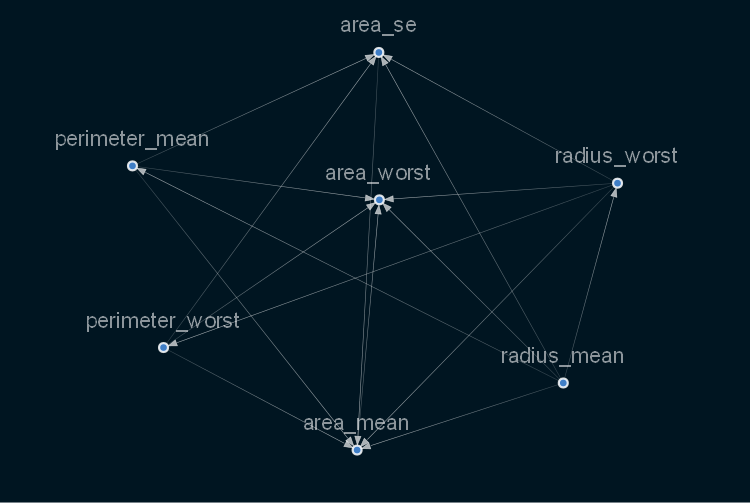

In [38]:
%%time
            
sm = from_pandas_lasso(x_portion,
                       tabu_parent_nodes=['diagnosis'],
                       w_threshold=0.3,
                       beta=0.8)
sm = sm.get_largest_subgraph()
vis_sm(sm)

## <b>Modelling</b>

#### Bayesian Modelling

In [51]:
df = selected_feat
original_y = target_df.apply(lambda x: 0 if x=="B" else 1)
original_full = df.copy()
original_full["target"] = original_y
original_full.head()
# df.head()
# df = x.iloc[:, :9]
# df.head()

,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,target
0,17.99,10.38,0.11840,0.3001,1.0950,0.04904,0.1622,0.6656,0.7119,0.4601,1
1,20.57,17.77,0.08474,0.0869,0.5435,0.01308,0.1238,0.1866,0.2416,0.2750,1
2,19.69,21.25,0.10960,0.1974,0.7456,0.04006,0.1444,0.4245,0.4504,0.3613,1
3,11.42,20.38,0.14250,0.2414,0.4956,0.07458,0.2098,0.8663,0.6869,0.6638,1
4,20.29,14.34,0.10030,0.1980,0.7572,0.02461,0.1374,0.2050,0.4000,0.2364,1


In [57]:
df['target'] = original_y
df.head()

C:\Users\wakur\AppData\Local\Temp\ipykernel_17304\631481630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['target'] = original_y


,radius_mean,texture_mean,smoothness_mean,concavity_mean,radius_se,compactness_se,smoothness_worst,compactness_worst,concavity_worst,symmetry_worst,target
0,17.99,10.38,0.11840,0.3001,1.0950,0.04904,0.1622,0.6656,0.7119,0.4601,1
1,20.57,17.77,0.08474,0.0869,0.5435,0.01308,0.1238,0.1866,0.2416,0.2750,1
2,19.69,21.25,0.10960,0.1974,0.7456,0.04006,0.1444,0.4245,0.4504,0.3613,1
3,11.42,20.38,0.14250,0.2414,0.4956,0.07458,0.2098,0.8663,0.6869,0.6638,1
4,20.29,14.34,0.10030,0.1980,0.7572,0.02461,0.1374,0.2050,0.4000,0.2364,1


In [60]:
# Extracting the markov_blanket
sm = from_pandas(df)
sm.remove_edges_below_threshold(0.3)
sm=sm.get_largest_subgraph()
bn = BayesianNetwork(sm)
blanket=get_markov_blanket(bn, 'target')

parents = set()
for item in blanket.edges:
    for val in item:
        if(val != "target"):
            parents.add(val)
parents = list(parents)
features = selected_feat.columns.to_list()
compact_feats = features[parents]
filtered = compact_feats[0]


TypeError: list indices must be integers or slices, not list

C:\Users\wakur\AppData\Roaming\Python\Python38\site-packages\pgmpy\models\BayesianModel.py:8: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  warnings.warn(


C:\Users\wakur\anaconda3\envs\causal-inference\lib\site-packages\pygraphviz\agraph.py:1405: RuntimeWarning: Warning: node 'diagnosis', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


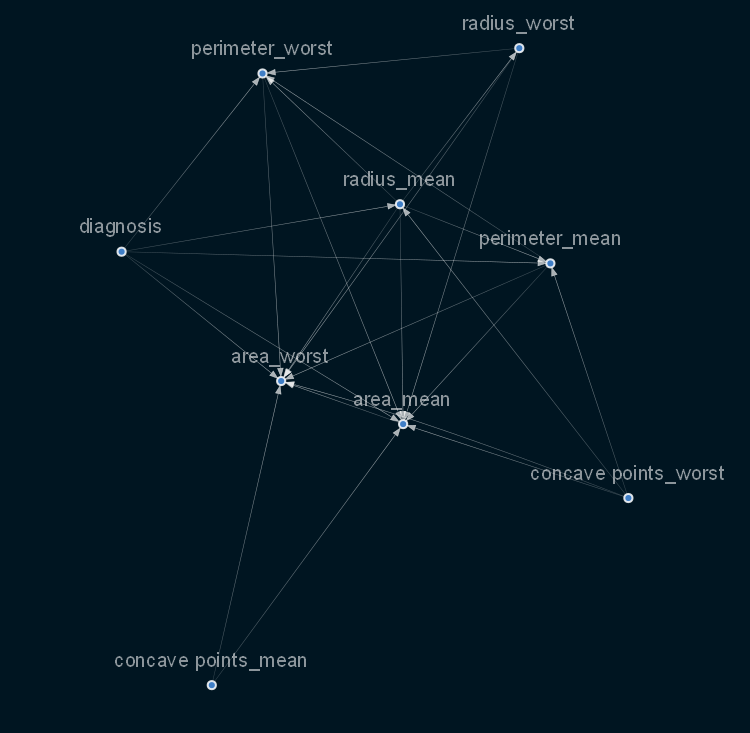

In [43]:
vis_sm(blanket.structure)

In [52]:
tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
            mode="single", 
            tree_params={"max_depth": 2, "random_state": 2022},
        )
        tree_discretiser.fit(
            feat_names=features_list, 
            dataframe=df, 
            target_continuous=True,
            target=target_name,
        )
features_list = [df.
desc_df = df.copy()
        for col in features_list:
            desc_df[col] = tree_discretiser.transform(desc_df[[col]])

,diagnosis,perimeter_worst,area_worst,radius_worst,concave points_worst,concave points_mean,perimeter_mean,area_mean,radius_mean,area_se,...,texture_mean,symmetry_worst,concavity_se,smoothness_mean,symmetry_mean,compactness_se,fractal_dimension_worst,fractal_dimension_se,texture_se,fractal_dimension_mean
0,1,184.60,2019.0,25.38,0.2654,0.14710,122.80,1001.0,17.99,153.40,...,10.38,0.4601,0.05373,0.11840,0.2419,0.04904,0.11890,0.006193,0.9053,0.07871
1,1,158.80,1956.0,24.99,0.1860,0.07017,132.90,1326.0,20.57,74.08,...,17.77,0.2750,0.01860,0.08474,0.1812,0.01308,0.08902,0.003532,0.7339,0.05667
2,1,152.50,1709.0,23.57,0.2430,0.12790,130.00,1203.0,19.69,94.03,...,21.25,0.3613,0.03832,0.10960,0.2069,0.04006,0.08758,0.004571,0.7869,0.05999
3,1,98.87,567.7,14.91,0.2575,0.10520,77.58,386.1,11.42,27.23,...,20.38,0.6638,0.05661,0.14250,0.2597,0.07458,0.17300,0.009208,1.1560,0.09744
4,1,152.20,1575.0,22.54,0.1625,0.10430,135.10,1297.0,20.29,94.44,...,14.34,0.2364,0.05688,0.10030,0.1809,0.02461,0.07678,0.005115,0.7813,0.05883
